## Section2_Databases

You are the tech lead for an e-commerce company that operates on the cloud. The company allows users to sign up as members on their website and make puchases on items listed. You are required to design and implement a pipeline that processes membership applications and determine if an application is successful or unsuccessful. Applications are dropped into a location for processing. Engineers have already written code to determine a successful or unsuccessful application, as well as creating membership IDs for successful applications. You may use the processed datasets from section 1 as reference. Successful applications should be sent to a location for storage and refrence.

The e-commerce company also requires you to set up a database for their sales transactions. Set up a PostgreSQL database using the Docker image provided. We expect at least a Dockerfile which will stand up your database with the DDL statements to create the necessary tables.vYou are required to produce entity-relationship diagrams as necessary to illustrate your design, along with the DDL statements that will be required to stand up the databse. The following are known for each item listed for sale on the e-commerce website:

Item Name
Manufacturer Name
Cost
Weight (in kg)
Each transaction made by a member contains the following information:

Membership ID
Items bought
Total items price
Total items weight
Analysts from the e-commerce company will need to query some information from the database. Below are 2 of the sameple queries from the analysts. Do note to design your database to account for a wide range of business use cases and queries. You are tasked to write a SQL statement for each of the following task:

Which are the top 10 members by spending
Which are the top 3 items that are frequently brought by members

### ERD Diagram

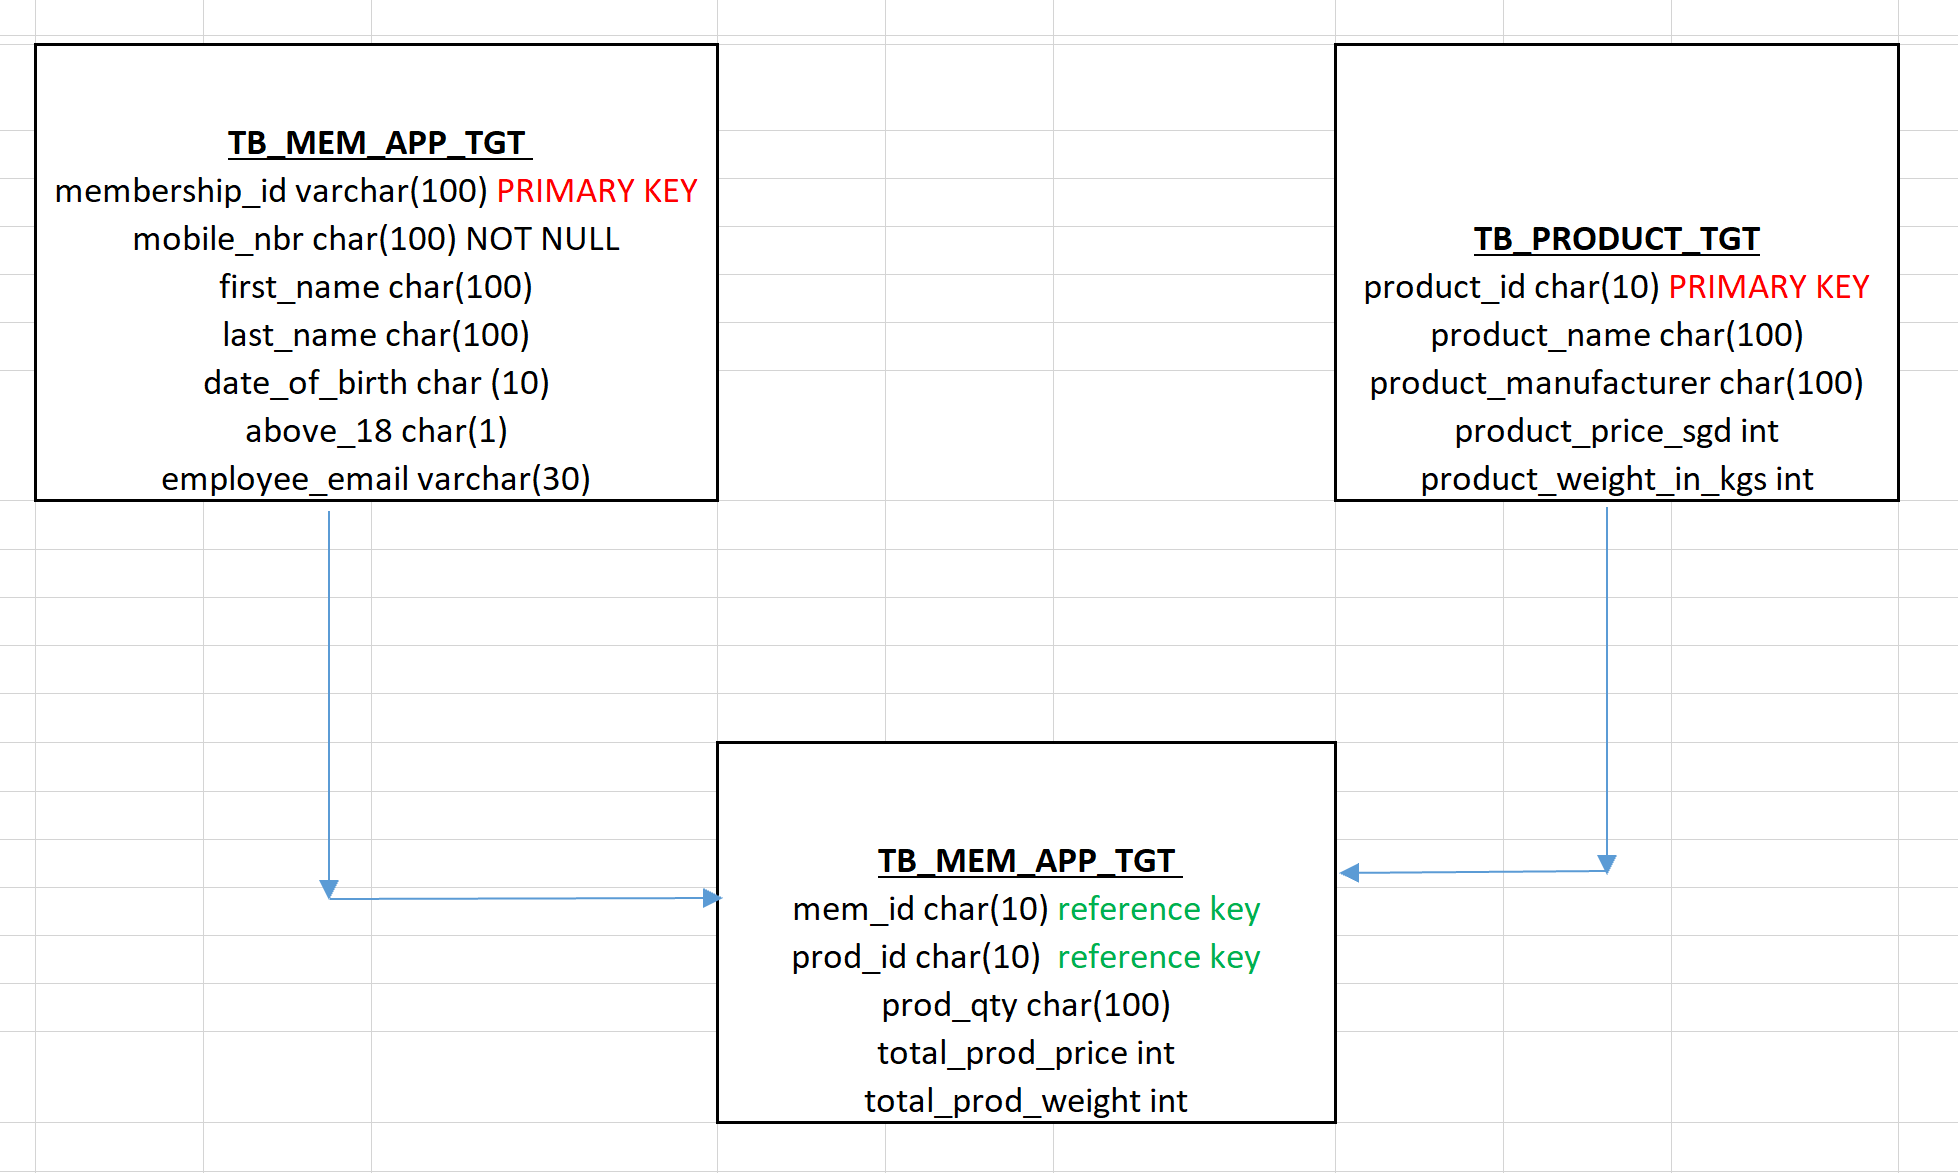

###  Data Loading: deriving filepath, defining getfiles function to retrieve the files

In [69]:
import os
file_dir = os.getcwd()
file_dir_input = os.path.join(file_dir, 'input_section2')
file_dir_input_sales = os.path.join(file_dir, 'input_section2a')
file_dir_archive =  os.path.join(file_dir, 'archive') 
print(file_dir_input)
print(file_dir_input_sales)
print(file_dir_archive)

def get_files_in_dir(input, extension = 'csv'):
    files = os.listdir(input)
    if extension is not None: # we have a filter 
        files = [f for f in files if f.endswith(extension)]
    return files


C:\Users\Jayanthi\Desktop\Jobs\GovTech\input_section2
C:\Users\Jayanthi\Desktop\Jobs\GovTech\input_section2a
C:\Users\Jayanthi\Desktop\Jobs\GovTech\archive


###  Data Loading: to list the files

In [70]:
import csv 
files = get_files_in_dir(file_dir_input)
print(files)

salesfiles = get_files_in_dir(file_dir_input_sales)
print(salesfiles)

['product_details_001.csv']
['sales_details_001.csv']


###  Data Loading: to TB_PRODUCT_TGT table

In [34]:

import psycopg2
  
conn = psycopg2.connect(dbname="postgres",
                        user='postgres', password='15253545', 
                        host='localhost', port='5432'
)
  
conn.autocommit = True
cursor = conn.cursor()
  
sql = '''DROP TABLE IF EXISTS TB_PRODUCT_TGT;'''
 
cursor.execute(sql)
#mobile number should be of 8 characters
sql1 = '''CREATE TABLE TB_PRODUCT_TGT(product_id char(10) PRIMARY KEY,\
product_name char(100),\
product_manufacturer char(100),\
product_price_sgd int,\
product_weight_in_kgs int);'''
  
  
cursor.execute(sql1)

for i in files:
     
    
        product_details_filepath = os.path.join(file_dir_input, i)
        print(product_details_filepath)

        try:
                    product_details_file = open(product_details_filepath)
                    product_details_data = csv.reader(product_details_file)
                    print(product_details_data)

        except FileNotFoundError:
                print('product_details_file not found')    

        sql1 = '''INSERT INTO TB_PRODUCT_TGT(product_id, product_name,\
        product_manufacturer,product_price_sgd,product_weight_in_kgs) VALUES (%s,%s,%s,%s, %s) ''' 
        cursor.executemany(sql1, product_details_data)
 
  
sql2 = '''select product_id from TB_PRODUCT_TGT;'''
cursor.execute(sql2)
for i in cursor.fetchall():
    print(i)
  
conn.commit()
conn.close()



C:\Users\Jayanthi\Desktop\Jobs\GovTech\input_section2\product_details_001.csv
('bos_123   ',)
('bos_456   ',)
('bos_789   ',)
('mit_123   ',)
('mit_456   ',)
('mit_789   ',)
('phi_123   ',)
('phi_456   ',)
('phi_789   ',)


###  Data Loading: to TB_SALES_TGT table
###  Data Updating: TB_SALES_TGT table by deriving the metrics for analysis

In [52]:
conn = psycopg2.connect(dbname="postgres",
                        user='postgres', password='15253545', 
                        host='localhost', port='5432'
)
  
conn.autocommit = True
cursor = conn.cursor()

sql = '''DROP TABLE IF EXISTS TB_SALES_TGT;''' 
cursor.execute(sql)

 
sql1 = '''CREATE TABLE TB_SALES_TGT(mem_id char(10) ,\
prod_id char(10) ,\
prod_qty char(100),\
total_prod_price int,\
total_prod_weight int);'''

cursor.execute(sql1)

for i in salesfiles:
     
    
        salesfiles_filepath = os.path.join(file_dir_input_sales, i)
        print(salesfiles_filepath)

        try:
                    salesfiles_details_file = open(salesfiles_filepath)
                    salesfiles_data = csv.reader(salesfiles_details_file)
                    print(salesfiles_data)

        except FileNotFoundError:
                print('salesfiles_file not found')    

        sql1 = '''INSERT INTO TB_SALES_TGT(mem_id, prod_id,\
        prod_qty) VALUES (%s,%s,%s) ''' 
        cursor.executemany(sql1, salesfiles_data)
 
  
 
    
########table_joins############
sql_join1 = '''UPDATE TB_SALES_TGT tb set total_prod_price = (select a.prod_qty::int * b.product_price_sgd::int from TB_SALES_TGT a, TB_PRODUCT_TGT b where a.prod_id = b.product_id and tb.mem_id = a.mem_id and tb.prod_id = a.prod_id ) '''
cursor.execute(sql_join1)

sql_join2 = '''UPDATE TB_SALES_TGT tb set total_prod_weight = (select a.prod_qty::int * b.product_weight_in_kgs::int from TB_SALES_TGT a, TB_PRODUCT_TGT b where a.prod_id = b.product_id and tb.mem_id = a.mem_id and tb.prod_id = a.prod_id ) '''
cursor.execute(sql_join2)


conn.commit()
conn.close()
 

C:\Users\Jayanthi\Desktop\Jobs\GovTech\input_section2a\sales_details_001.csv
('3f8ed', 'jack', 'alexander', 'phi_789', '10', 13000, 20)
('3f8ed', 'jack', 'alexander', 'bos_456', '1', 2000, 20)
('e6202', 'john', 'abhraham', 'bos_789', '1', 1500, 10)


### Output of top 3 members by spending
### Output of top 3 items that are frequently brought by members

In [68]:
conn = psycopg2.connect(dbname="postgres",
                        user='postgres', password='15253545', 
                        host='localhost', port='5432'
)
  
conn.autocommit = True
cursor = conn.cursor()


sql_op = '''select  trim(mem_id), trim(last_name) ,trim(prod_id),  trim(prod_qty), total_prod_price , total_prod_weight  from TB_SALES_TGT sales, TB_MEM_APP_TGT mem where mem.membership_id = sales.mem_id order by total_prod_price desc LIMIT 3;'''
cursor.execute(sql_op)

print('top 3 members by spending')
print('-------------------------')
for i in cursor.fetchall():
    print(i)

    
sql_op1 = '''select   trim(prod_id),  trim(product_name), trim(prod_qty)   from TB_SALES_TGT sales, TB_PRODUCT_TGT prod where prod.product_id = sales.prod_id order by prod_qty desc LIMIT 3;'''
cursor.execute(sql_op1)

print('\n')
print('top 3 product by members')
print('-------------------------')
for j in cursor.fetchall():
    print(j)

top 3 members by spending
-------------------------
('3f8ed', 'alexander', 'phi_789', '10', 13000, 20)
('3f8ed', 'alexander', 'bos_456', '1', 2000, 20)
('e6202', 'abhraham', 'bos_789', '1', 1500, 10)


top 3 product by members
-------------------------
('phi_123', 'tooth_brush', '10')
('phi_789', 'iron', '10')
('bos_789', 'dish_washer', '1')
